In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import argparse
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F

sys.path.append("../../")
from src.filepath import ABSOLUTE_PATH
from src.model.diffusion import GaussianDiffusion
from src.model.UNet2d import Unet2D
from src.model.fno import FNO2D
from src.inference.compose import compose_diffusion, compose_diffusion_ddim
from src.utils.utils import plot_compare_2d, relative_error, get_parameter_net
from src.train.reaction_diffusion import cond_emb, renormalize
from src.train.reaction_diffusion import normalize_to_neg_one_to_one as normalize

d:\Anaconda\envs\mpd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\vscode\research\multphysics_simulation\src\inference\../..\src\model\diffusion.py:478: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [2]:
model_type = "FNO"
ddim = False
eta = 1

## load model

In [3]:
dim = 24
out_dim = 1
channel = 3
nx = 20
diffusion_step = 250
ddim_step = 10 if ddim else diffusion_step
device = "cuda"
if model_type == "Unet":
    model1 = Unet2D(dim=dim, cond_emb=cond_emb(), out_dim=out_dim, dim_mults=(1, 2), channels=channel)
    model2 = Unet2D(dim=dim, cond_emb=cond_emb(), out_dim=out_dim, dim_mults=(1, 2), channels=channel)
elif model_type == "FNO":
    model1 = FNO2D(
        in_channels=channel,
        out_channels=out_dim,
        nr_fno_layers=4,
        fno_layer_size=24,
        fno_modes=[6, 12],
        time_input=True,
        cond_emb=cond_emb(),
    )
    model2 = FNO2D(
        in_channels=channel,
        out_channels=out_dim,
        nr_fno_layers=4,
        fno_layer_size=24,
        fno_modes=[6, 12],
        time_input=True,
        cond_emb=cond_emb(),
    )
diffusion1 = GaussianDiffusion(
    model1,
    seq_length=(out_dim, 10, nx),
    timesteps=diffusion_step,
    ddim_sampling_eta=eta,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
).to(device)
diffusion2 = GaussianDiffusion(
    model2,
    seq_length=(out_dim, 10, nx),
    timesteps=diffusion_step,
    ddim_sampling_eta=eta,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
).to(device)

In [4]:
if model_type == "Unet":
    diffusion1.load_state_dict(torch.load("../../results/reaction_diffusion/diffusionUnetu10000/model.pt")["model"])
    diffusion2.load_state_dict(torch.load("../../results/reaction_diffusion/diffusionUnetv10000/model.pt")["model"])
elif model_type == "FNO":
    diffusion1.load_state_dict(torch.load("../../results/reaction_diffusion/diffusionFNOu10000/model-100.pt")["model"])
    diffusion2.load_state_dict(torch.load("../../results/reaction_diffusion/diffusionFNOv10000/model-100.pt")["model"])

C:\Users\taozhan\AppData\Local\Temp\ipykernel_31836\4015162890.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion1.load_state_dict(torch.load("../../results/react

validation of u

In [5]:
# for i in range(10, 101):
#     diffusion2.load_state_dict(
#         torch.load("../../results/reaction_diffusion/diffusionFNOu10000/model-" + str(i) + ".pt")["model"]
#     )
data = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_u_from_v_u.npy")).float().to("cuda")[9000:]
)
cond = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_u_from_v_v.npy")).float().to("cuda")[9000:]
)

data = torch.tensor(data).unsqueeze(1)

cond1 = torch.tensor(cond).unsqueeze(1)

cond2 = data[:, :, 0:1].clone().expand(-1, -1, data.shape[2], -1)

cond = torch.concat((cond1, cond2), dim=1)

u_pred = renormalize(diffusion1.sample(cond.shape[0], cond=[normalize(cond)]))

rmse = relative_error(data, u_pred)
rmse

C:\Users\taozhan\AppData\Local\Temp\ipykernel_31836\1991230862.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)
C:\Users\taozhan\AppData\Local\Temp\ipykernel_31836\1991230862.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond1 = torch.tensor(cond).unsqueeze(1)
sampling loop time step: 100%|██████████| 250/250 [00:06<00:00, 39.14it/s]


0.026992683410644532

flops calculate

In [6]:
# from thop import profile


# class FLOPS(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, shape, cond):
#         return self.model.sample(shape, cond=cond)


# flops = FLOPS(diffusion1)
# flops, params = profile(flops, (1, [normalize(cond[0:1])]))
# print("flops: %.2f M, params: %.2f M" % (flops / 1e6 / ddim_step, params / 1e6))

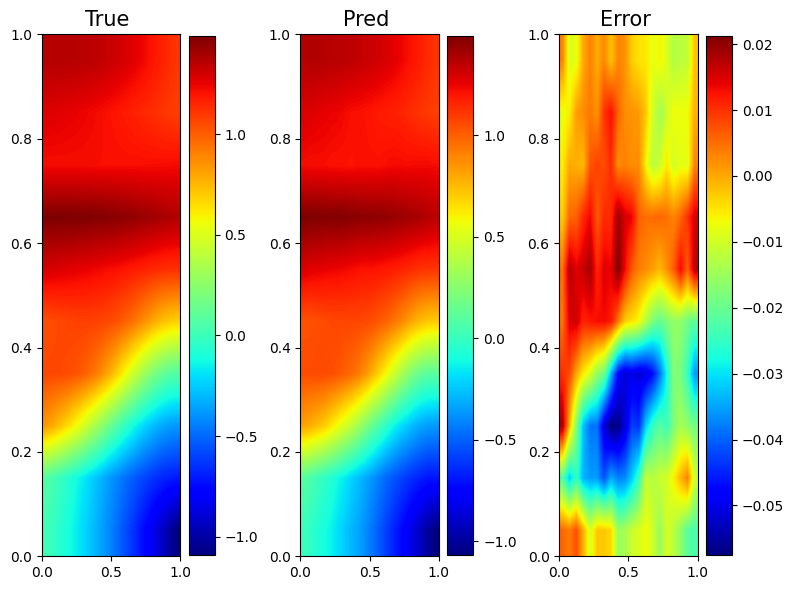

In [7]:
random_n = np.random.randint(0, data.shape[0])
plot_compare_2d(
    true_d=data[random_n, 0],
    pred_d=u_pred[random_n, 0],
)
# plot_compare_2d(data, un(u_pred))

validation of v

In [8]:
# for i in range(51, 91):
#     diffusion2.load_state_dict(
#         torch.load("../../results/reaction_diffusion/diffusionFNOv10000/model-" + str(i) + ".pt")["model"]
#     )
data = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_v_from_u_v.npy")).float().to("cuda")[9000:]
)
cond = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_v_from_u_u.npy")).float().to("cuda")[9000:]
)


data = torch.tensor(data).unsqueeze(1)


cond1 = torch.tensor(cond).unsqueeze(1)


cond2 = data[:, :, 0:1].clone().expand(-1, -1, data.shape[2], -1)


cond = torch.concat((cond1, cond2), dim=1)


v_pred = renormalize(diffusion2.sample(cond.shape[0], cond=[normalize(cond)]))


rmse = relative_error(data, v_pred)
print(rmse)

C:\Users\taozhan\AppData\Local\Temp\ipykernel_31836\1290186009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)
C:\Users\taozhan\AppData\Local\Temp\ipykernel_31836\1290186009.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond1 = torch.tensor(cond).unsqueeze(1)
sampling loop time step: 100%|██████████| 250/250 [00:06<00:00, 41.60it/s]


0.010245688438415527


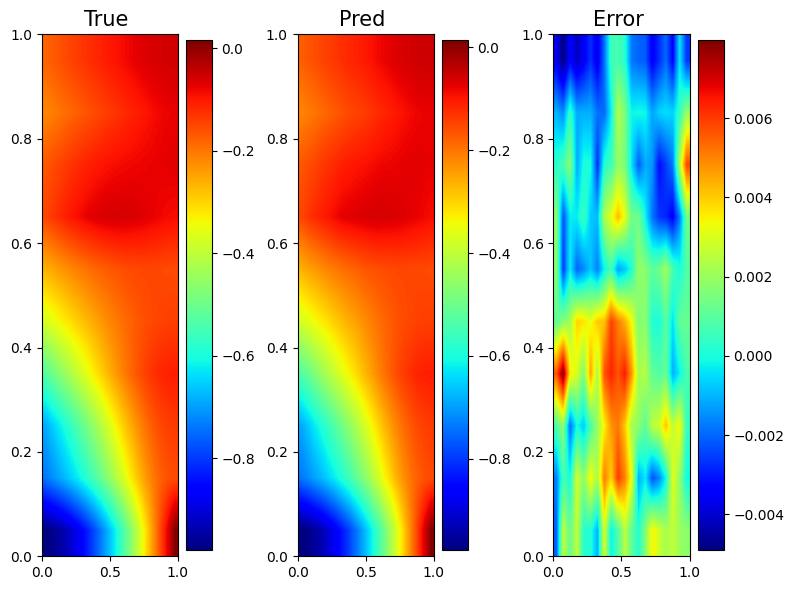

In [9]:
random_n = np.random.randint(0, data.shape[0])
plot_compare_2d(
    true_d=data[random_n, 0],
    pred_d=(v_pred)[random_n, 0],
)
# plot_compare_2d(data, un(u_pred))

## compose

In [10]:
data = (
    torch.tensor(np.load(ABSOLUTE_PATH + "/data/reaction_diffusion/reaction_diffusion_uv.npy"))
    .float()
    .to("cuda")[:2000]
)
# data = (data + 5) / 10

data = data.permute(0, 2, 1)

# data1 = np.load('../../data/reaction_diffusion_u_from_v_u.npy')

u, v = data[..., :20].unsqueeze(1), data[..., 20:].unsqueeze(1)

u_intial, v_intial = u[:, :, 0:1].expand(-1, -1, 10, -1), v[:, :, 0:1].expand(-1, -1, 10, -1)

u.shape, u_intial.shape

(torch.Size([2000, 1, 10, 20]), torch.Size([2000, 1, 10, 20]))

In [11]:
def update_u(alpha, mult_p_estimate, mult_p_estimate_before, other_condition, normalize, renormalize):
    weight_field = []
    for i in range(len(mult_p_estimate)):
        weight_field.append(alpha * mult_p_estimate[i] + (1 - alpha) * mult_p_estimate_before[i])
    intial_u, intial_v = other_condition[0], other_condition[1]
    cond = [torch.concat((weight_field[1], intial_u), dim=1)]
    return cond


def update_v(alpha, mult_p_estimate, mult_p_estimate_before, other_condition, normalize, renormalize):
    weight_field = []
    for i in range(len(mult_p_estimate)):
        weight_field.append(alpha * mult_p_estimate[i] + (1 - alpha) * mult_p_estimate_before[i])
    intial_u, intial_v = other_condition[0], other_condition[1]
    cond = [torch.concat((weight_field[0], intial_v), dim=1)]
    return cond

In [12]:
model_lis = [diffusion1, diffusion2]
if not ddim:

    mult_p = compose_diffusion(
        model_list=model_lis,
        shape=[(u.shape[0], 1, 10, 20), (u.shape[0], 1, 10, 20)],
        other_condition=[normalize(u_intial), normalize(v_intial)],
        update_f=[update_u, update_v],
        normalize_f=[normalize, normalize],
        unnormalize_f=[renormalize, renormalize],
        num_iter=2,
        device="cuda",
    )
else:
    mult_p = compose_diffusion_ddim(
        model_list=model_lis,
        shape=[(u.shape[0], 1, 10, 20), (u.shape[0], 1, 10, 20)],
        other_condition=[normalize(u_intial), normalize(v_intial)],
        update_f=[update_u, update_v],
        normalize_f=[normalize, normalize],
        unnormalize_f=[renormalize, renormalize],
        num_iter=2,
        device="cuda",
    )

sampling loop time step: 100%|██████████| 250/250 [00:26<00:00,  9.58it/s]


In [13]:
mult_p_true = torch.concat((u, v), dim=1)
mult_p_pred = renormalize(torch.concat((mult_p[0], mult_p[1]), dim=1))


mult_p_true.shape, mult_p_pred.shape

(torch.Size([2000, 2, 10, 20]), torch.Size([2000, 2, 10, 20]))

In [14]:
relative_error(mult_p_pred[:, 0], mult_p_true[:, 0]), relative_error(mult_p_pred[:, 1], mult_p_true[:, 1])

(0.02895379638671875, 0.026434152603149415)

iter 1  
use trick 1.70e-2 1.95e-2   
unuse trick 1.69e-2 1.95e-2

iter 2  
use trick 1.70e-2 1.94e-2   
unuse trick 1.68e-2 1.94e-2

(tensor(8.9275e-06, device='cuda:0'),
 tensor(1.4842e-05, device='cuda:0'),
 tensor(3.0127e-06, device='cuda:0'))

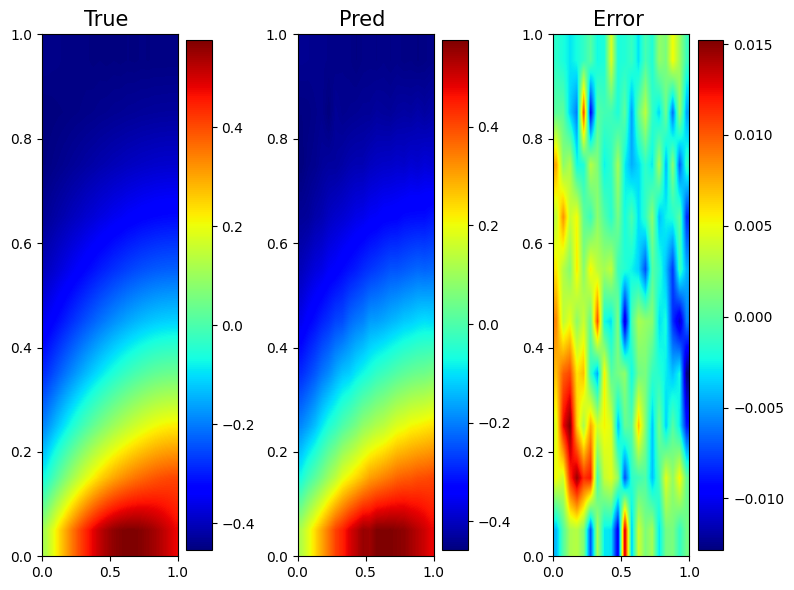

In [76]:
random_n = np.random.randint(0, data.shape[0])
random_n = -1


plot_compare_2d(
    true_d=mult_p_true[random_n, 1],
    pred_d=mult_p_pred[random_n, 1],
    savep=ABSOLUTE_PATH + "/results/reaction_diffusion/diffusion.pdf",
)